In [29]:
#Acessando o NDVI via GEE

import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1Ab_5qlld2DZFuqsNk7l5t25iH6s-3uvKKFQMg_8O9im6Wfah8uC2JcM65-M



Successfully saved authorization token.


In [28]:
#Fazendo a importação da API com os dados do PNADC

import requests
import pandas as pd

# URL da API do PNADC
url = 'https://servicodados.ibge.gov.br/api/v3/agregados/4095/periodos/202401|202402|202403|202404/variaveis/4092|4093|4110|4111|4094|4095|4112|4113|4098|4102|4099|4103|12466|12467|4723|4724|4726|4774?localidades=N6[N2[1,2,3,4,5],N3[11,12,13,14,15,16,17,21,22,23,24,25,26,27,28,29,31,32,33,35,41,42,43,50,51,52,53]]&classificacao=1568[120706,11779,11628,11629]'

# Fazer a requisição à API
response = requests.get(url)

# Verificar se a requisição foi bem-sucedida
if response.status_code == 200:
    dados_pnadc = response.json()
else:
    raise Exception(f"Erro na requisição: {response.status_code}")

# Processar os dados da API
linhas = []

for agregado in dados_pnadc:
    variavel = agregado['variavel']
    unidade = agregado['unidade']
    
    for resultado in agregado['resultados']:
        classificacoes = resultado['classificacoes']
        
        # Obter Nível de Instrução
        nivel_instrucao = None
        for classificacao in classificacoes:
            if classificacao['id'] == '1568':
                nivel_instrucao = list(classificacao['categoria'].values())[0]
                break
        
        # Processar séries temporais
        for serie in resultado['series']:
            localidade = serie.get('localidade', {})
            codigo_municipio = localidade.get('id', None)
            estado = localidade.get('nome', 'Desconhecido')
            
            for periodo, valor in serie['serie'].items():
                valor_float = float(valor.replace(',', '.')) if valor and valor != '-' else None
                
                linhas.append({
                    'Periodo': periodo,
                    'Estado': estado,
                    'Variavel': variavel,
                    'Unidade': unidade,
                    'Nivel_Instrucao': nivel_instrucao,
                    'Valor': valor_float
                })

# Criar DataFrame
df_pnadc = pd.DataFrame(linhas)

# Remover valores desconhecidos e duplicados
df_pnadc.dropna(subset=['Estado', 'Valor'], inplace=True)

# Salvar o arquivo CSV
df_pnadc.to_csv('ndvi-empregabilidade-verde-brasil/dados/pnadc_2024.csv', index=False)

print("✅ Arquivo 'pnadc_2024.csv' gerado com sucesso.")

✅ Arquivo 'pnadc_2024.csv' gerado com sucesso.


In [31]:
import ee
import geemap

# Inicializa o Earth Engine
ee.Initialize()

# 1) Carregar NDVI de 2024 (MODIS) e calcular a média
dataset = (ee.ImageCollection('MODIS/061/MOD13Q1')
             .filter(ee.Filter.date('2024-01-01', '2024-12-31'))
             .select('NDVI'))
ndvi_2024 = dataset.mean()

# 2) Carregar limites dos estados do Brasil
br_states = (ee.FeatureCollection("FAO/GAUL/2015/level1")
             .filter(ee.Filter.eq('ADM0_NAME', 'Brazil')))

# 3) Criar um dicionário que agrupa os estados por região
region_dict = {
    "Norte": ["Acre", "Amazonas", "Roraima", "Rondonia", "Para", "Amapa", "Tocantins"],
    "Nordeste": ["Maranhao", "Piaui", "Ceara", "Rio Grande Do Norte", "Paraiba",
                 "Pernambuco", "Alagoas", "Sergipe", "Bahia"],
    "Centro-Oeste": ["Mato Grosso", "Mato Grosso Do Sul", "Goias", "Distrito Federal"],
    "Sudeste": ["Sao Paulo", "Rio De Janeiro", "Espirito Santo", "Minas Gerais"],
    "Sul": ["Parana", "Santa Catarina", "Rio Grande Do Sul"]
}

# 4) Criar uma FeatureCollection para as regiões
regions = []
for region, states in region_dict.items():
    region_fc = br_states.filter(ee.Filter.inList('ADM1_NAME', states))
    region_geom = region_fc.geometry().dissolve()  # Une os estados em uma única geometria
    region_feature = ee.Feature(region_geom, {"Região": region})
    regions.append(region_feature)

br_regions = ee.FeatureCollection(regions)

# 5) Criar o mapa centrado no Brasil
Map = geemap.Map(center=[-15, -55], zoom=4)

# 6) Definir nova paleta de cores conforme solicitado
ndviVis = {
    'min': 0.0,
    'max': 9000.0,
    'palette': ['white', 'blue', 'red', 'yellow', 'green']
}

# 7) Recortar NDVI ao território brasileiro
ndvi_clip = ndvi_2024.clip(br_states)

# 8) Adicionar a camada NDVI recortada ao mapa
Map.addLayer(ndvi_clip, ndviVis, 'NDVI 2024')

# 9) Adicionar fronteiras das regiões (em vez dos estados)
borders_style = {
    'color': 'black',
    'width': 2
}
Map.addLayer(br_regions.style(**borders_style), {}, "Fronteiras das Regiões")

# 10) Adicionar rótulos das regiões brasileiras
Map.add_labels(
    data=br_regions,  
    column="Região",  
    font_size='16pt',       # Maior para destacar bem
    font_color='white',     # Branco para legibilidade
    halo=True,              # Adiciona borda preta
    halo_color='gray'
)

# 11) Adicionar uma legenda NDVI com as novas cores
legend_dict = {
    'NDVI Muito Baixo (0 - 0.1)': '#ffffff',
    'NDVI Baixo (0.1 - 0.3)': '#0000ff',
    'NDVI Moderado (0.3 - 0.6)': '#ff0000',
    'NDVI Alto (0.6 - 0.8)': '#ffff00',
    'NDVI Muito Alto (0.8 - 1.0)': '#008000'
}

Map.add_legend(title="NDVI (escala MODIS)", legend_dict=legend_dict)

# 12) Adicionar controle de camadas
Map.addLayerControl()

Map

Map(center=[-15, -55], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [27]:
# Correção da Base PNADC: Restauração de UF e Criação das Colunas de Estado e Região

import pandas as pd

# Carregar o arquivo CSV com os dados do PNADC
df_pnadc = pd.read_csv('ndvi-empregabilidade-verde-brasil/dados/pnadc_2024.csv')

# Dicionário de estados por UF
uf_para_estado = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AP': 'Amapá', 'AM': 'Amazonas',
    'BA': 'Bahia', 'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo',
    'GO': 'Goiás', 'MA': 'Maranhão', 'MT': 'Mato Grosso', 'MS': 'Mato Grosso Do Sul',
    'MG': 'Minas Gerais', 'PA': 'Pará', 'PB': 'Paraíba', 'PR': 'Paraná',
    'PE': 'Pernambuco', 'PI': 'Piauí', 'RJ': 'Rio De Janeiro', 'RN': 'Rio Grande Do Norte',
    'RS': 'Rio Grande Do Sul', 'RO': 'Rondônia', 'RR': 'Roraima', 'SC': 'Santa Catarina',
    'SP': 'São Paulo', 'SE': 'Sergipe', 'TO': 'Tocantins'
}

# Dicionário de regiões
estados_regioes = {
    'Norte': ['Acre', 'Amapá', 'Amazonas', 'Pará', 'Rondônia', 'Roraima', 'Tocantins'],
    'Nordeste': ['Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba', 'Pernambuco', 'Piauí', 'Rio Grande Do Norte', 'Sergipe'],
    'Centro-Oeste': ['Distrito Federal', 'Goiás', 'Mato Grosso', 'Mato Grosso Do Sul'],
    'Sudeste': ['Espírito Santo', 'Minas Gerais', 'Rio De Janeiro', 'São Paulo'],
    'Sul': ['Paraná', 'Rio Grande Do Sul', 'Santa Catarina']
}

# Restaurar UF e gerar colunas de Estado e Região
df_pnadc['UF'] = df_pnadc['Estado'].str.extract(r'([A-Z]{2})$')
df_pnadc['Estado'] = df_pnadc['UF'].map(uf_para_estado)
df_pnadc['Regiao'] = df_pnadc['Estado'].apply(lambda x: next((regiao for regiao, estados in estados_regioes.items() if x in estados), None))

# Salvar o arquivo com as correções
df_pnadc.to_csv('ndvi-empregabilidade-verde-brasil/dados/pnadc_2024_revisado.csv', index=False)
print("Arquivo 'pnadc_2024_revisado.csv' gerado com sucesso!")

Arquivo 'pnadc_2024_revisado.csv' gerado com sucesso!


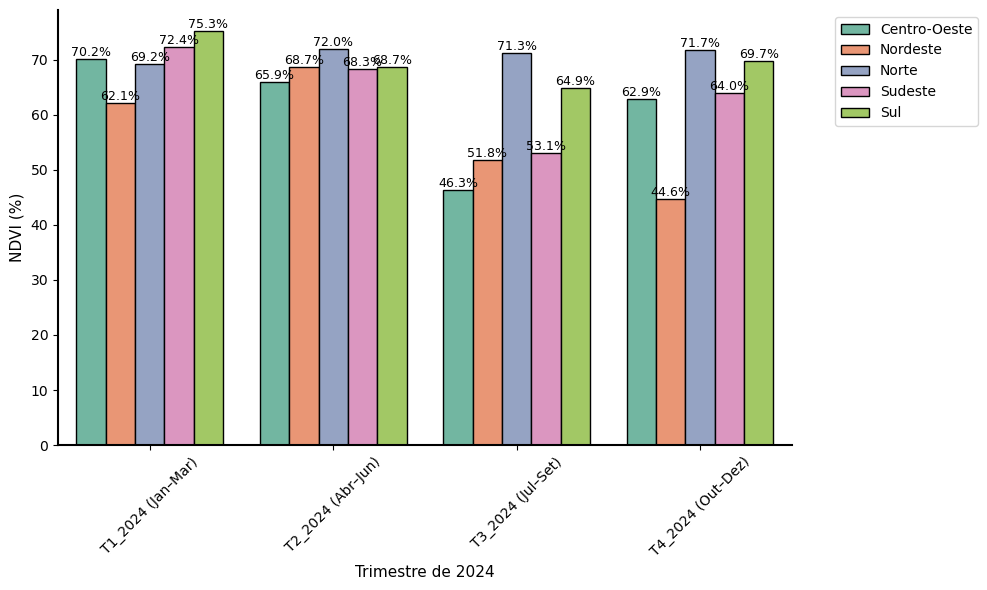

In [40]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Etapa 1: Carregar os dados de NDVI com identificação da região e trimestre
df = pd.read_csv("ndvi-empregabilidade-verde-brasil/dados/ndvi_completo_com_regiao_2024.csv")

# Etapa 2: Traduzir os trimestres em formato legível para o gráfico
map_trimestre = {
    "202401": "T1_2024 (Jan–Mar)",
    "202402": "T2_2024 (Abr–Jun)",
    "202403": "T3_2024 (Jul–Set)",
    "202404": "T4_2024 (Out–Dez)"
}
df["Trimestre"] = df["Trimestre"].astype(str).map(map_trimestre)

# Etapa 3: Calcular a média de NDVI por Região e Trimestre
df_agg = df.groupby(["Região", "Trimestre"])["NDVI"].mean().reset_index()

# Etapa 4: Converter valores de NDVI para porcentagem
df_agg["NDVI_perc"] = df_agg["NDVI"] * 100

# Etapa 5: Plotar gráfico de barras com formatação conforme norma USP ESALQ
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_agg,
    x="Trimestre",
    y="NDVI_perc",
    hue="Região",
    palette="Set2",
    ci=None,
    edgecolor="black"  # Adiciona contorno preto às barras
)

# Etapa 6: Remover elementos visuais não permitidos
ax.set_title("")  # Remover o título do gráfico
ax.grid(False)    # Remover linhas de grade
ax.set_facecolor("white")  # Fundo branco

# Etapa 7: Configurar eixos com linha preta e largura 1.5 pt
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_color('black')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Etapa 8: Ajustar eixos com fonte semelhante à Arial (instalada)
ax.set_xlabel("Trimestre de 2024", fontsize=11, fontname="DejaVu Sans", color="black")
ax.set_ylabel("NDVI (%)", fontsize=11, fontname="DejaVu Sans", color="black")

# Etapa 9: Estilizar os ticks dos eixos
plt.xticks(rotation=45, fontsize=10, fontname="DejaVu Sans", color="black")
plt.yticks(fontsize=10, fontname="DejaVu Sans", color="black")

# Etapa 10: Legenda no canto superior direito, sem título
plt.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10, prop={'family': 'DejaVu Sans'})

# Etapa 11: Adicionar rótulos com valores percentuais
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=9, fontname="DejaVu Sans", color="black")

# Etapa 12: Exportar gráfico para imagem
plt.savefig("ndvi-empregabilidade-verde-brasil/figuras/variacao_trimestral_NDV.png", dpi=300, bbox_inches="tight")

# Etapa final: Exibir gráfico
plt.tight_layout()
plt.show()

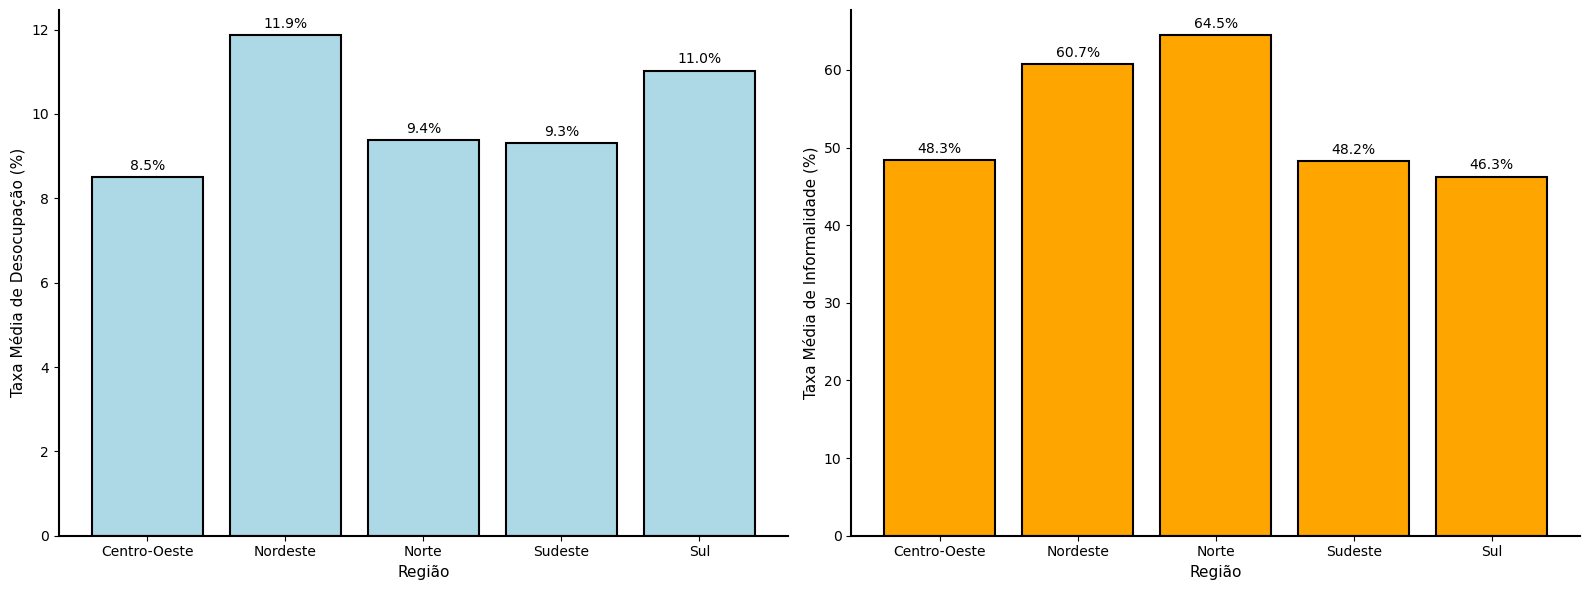

In [41]:
# Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt

# Etapa 1: Carregar os dados contendo taxas médias por região
df = pd.read_csv("ndvi-empregabilidade-verde-brasil/dados/df_clusters_com_regiao.csv")

# Etapa 2: Agrupar os dados por região e calcular as médias das taxas
df_pnadc_media_regiao = df.groupby("Região")[["Taxa_Desocupacao", "Taxa_Informalidade"]].mean().reset_index()

# Etapa 3: Criar dois gráficos lado a lado (subplots)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Etapa 4: Gráfico da taxa média de desocupação
bars1 = ax[0].bar(
    df_pnadc_media_regiao["Região"],
    df_pnadc_media_regiao["Taxa_Desocupacao"],
    color="lightblue",
    edgecolor="black",
    linewidth=1.5
)
ax[0].set_ylabel("Taxa Média de Desocupação (%)", fontsize=11, fontname="DejaVu Sans", color="black")
ax[0].set_xlabel("Região", fontsize=11, fontname="DejaVu Sans", color="black")
ax[0].spines['left'].set_linewidth(1.5)
ax[0].spines['bottom'].set_linewidth(1.5)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params(axis='x', colors='black')
ax[0].tick_params(axis='y', colors='black')
ax[0].bar_label(bars1, fmt="%.1f%%", padding=3, fontsize=10, fontname="DejaVu Sans", color="black")

# Etapa 5: Gráfico da taxa média de informalidade
bars2 = ax[1].bar(
    df_pnadc_media_regiao["Região"],
    df_pnadc_media_regiao["Taxa_Informalidade"],
    color="orange",
    edgecolor="black",
    linewidth=1.5
)
ax[1].set_ylabel("Taxa Média de Informalidade (%)", fontsize=11, fontname="DejaVu Sans", color="black")
ax[1].set_xlabel("Região", fontsize=11, fontname="DejaVu Sans", color="black")
ax[1].spines['left'].set_linewidth(1.5)
ax[1].spines['bottom'].set_linewidth(1.5)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params(axis='x', colors='black')
ax[1].tick_params(axis='y', colors='black')
ax[1].bar_label(bars2, fmt="%.1f%%", padding=3, fontsize=10, fontname="DejaVu Sans", color="black")

# Etapa 6: Ajustar o layout para melhor apresentação
plt.tight_layout()

# Etapa 7: Salvar a figura com alta qualidade para inserção no TCC
plt.savefig("ndvi-empregabilidade-verde-brasil/figuras/fig_pnadc_desocupacao_informalidade_regiao.png", dpi=300, bbox_inches="tight")

# Etapa final: Exibir o gráfico
plt.show()

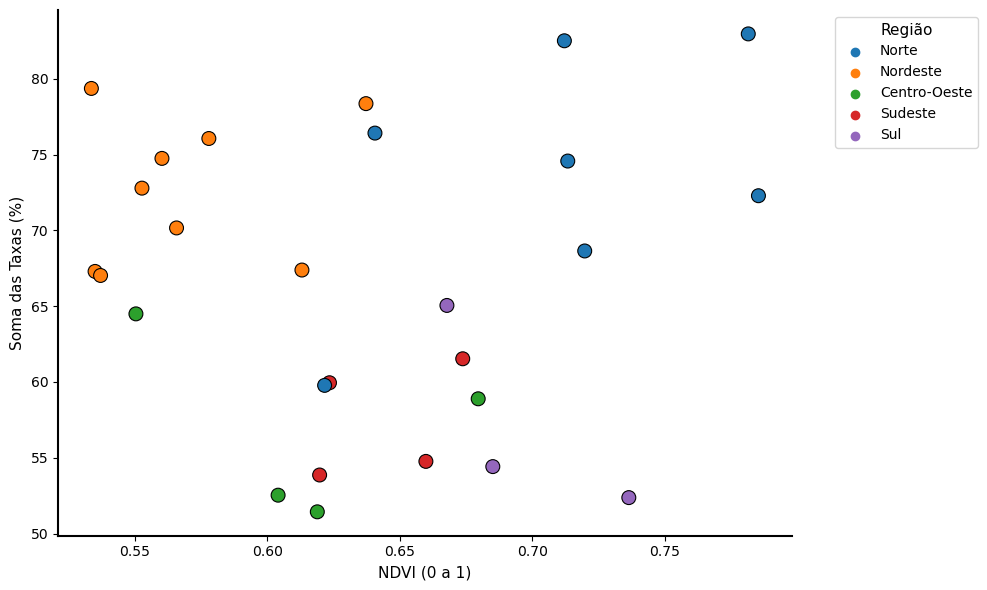

In [42]:
# ============================================================
# GRÁFICO 5: Dispersão entre NDVI e soma das taxas de desocupação e informalidade por estado
# OBJETIVO: Visualizar se há relação entre cobertura vegetal (NDVI) e vulnerabilidade socioeconômica
# FORMATAÇÃO: Conforme as normas da USP ESALQ – sem borda, sem título, eixos pretos (1,5 pt), sem preenchimento
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Etapa 1: Carrega os dados de NDVI e indicadores socioeconômicos por estado
df = pd.read_csv("ndvi-empregabilidade-verde-brasil/dados/df_clusters_com_regiao.csv")

# Etapa 2: Cria uma nova coluna com a soma das taxas de desocupação e informalidade
df["Soma_Taxas"] = df["Taxa_Desocupacao"] + df["Taxa_Informalidade"]

# Etapa 3: Agrupa por Estado e Região para calcular médias anuais
df_media = df.groupby(["Estado", "Região"]).agg({
    "NDVI": "mean",
    "Soma_Taxas": "mean"
}).reset_index()

# Etapa 4: Cria a figura e define o tamanho
plt.figure(figsize=(10, 6))

# Etapa 5: Cria o gráfico de dispersão colorindo os pontos por região
scatter = sns.scatterplot(
    data=df_media,
    x="NDVI",
    y="Soma_Taxas",
    hue="Região",
    s=100,               # Tamanho dos pontos
    edgecolor="black"    # Contorno preto para destaque
)

# Etapa 6: Remove o título e bordas superiores/direita
scatter.set_title("")         
sns.despine()                  

# Etapa 7: Garante fundo branco
scatter.set_facecolor("white")

# Etapa 8: Define apenas os eixos inferior e esquerdo com linha preta espessa
for spine in ["left", "bottom"]:
    scatter.spines[spine].set_linewidth(1.5)
    scatter.spines[spine].set_color("black")

# Etapa 9: Ajusta os rótulos dos eixos conforme norma (Arial → substituído por DejaVu Sans)
plt.xlabel("NDVI (0 a 1)", fontsize=11, fontname="DejaVu Sans", color="black")
plt.ylabel("Soma das Taxas (%)", fontsize=11, fontname="DejaVu Sans", color="black")

# Etapa 10: Configura os ticks com fonte preta e legível
plt.xticks(fontsize=10, fontname="DejaVu Sans", color="black")
plt.yticks(fontsize=10, fontname="DejaVu Sans", color="black")

# Etapa 11: Posiciona a legenda fora do gráfico
plt.legend(title="Região", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10, title_fontsize=11)

# Etapa 12: Ajusta layout para evitar cortes
plt.tight_layout()

# Etapa 13: Salva imagem em alta qualidade (300 dpi) para o TCC
plt.savefig("ndvi-empregabilidade-verde-brasil/figuras/figura_5_dispersao_ndvi_taxas.png", dpi=300, bbox_inches="tight")

# Etapa 14: Exibe o gráfico
plt.show()

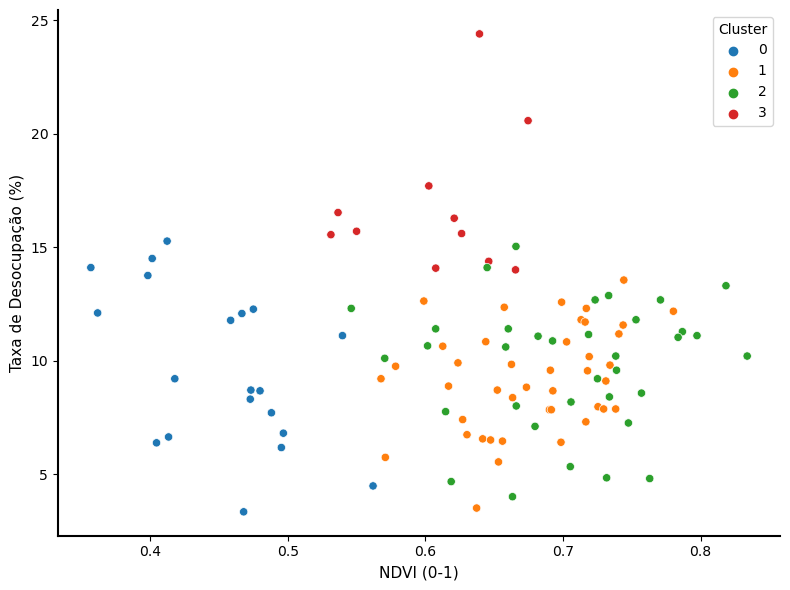

'ndvi-empregabilidade-verde-brasil/figuras/figura_ndvi_desocupacao_cluster.png'

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar os dados
df_clusters = pd.read_csv("ndvi-empregabilidade-verde-brasil/dados/df_pivotado_clusters.csv")

# Definir colunas com nomes longos
col_desocup = "Taxa de desocupação, na semana de referência, das pessoas de 14 anos ou mais de idade"

# Criar figura com tamanho adequado
fig, ax = plt.subplots(figsize=(8, 6))

# Criar o gráfico de dispersão com cores por cluster
scatter = sns.scatterplot(
    data=df_clusters,
    x='NDVI',
    y=col_desocup,
    hue='Cluster',
    palette='tab10',
    ax=ax
)

# Remover título e ajustar rótulos dos eixos conforme normas (usar DejaVu Sans por compatibilidade)
ax.set_title("")
ax.set_xlabel("NDVI (0-1)", fontsize=11, fontname="DejaVu Sans", color="black")
ax.set_ylabel("Taxa de Desocupação (%)", fontsize=11, fontname="DejaVu Sans", color="black")

# Estilo dos eixos principais: linha preta com 1.5 pt (demais invisíveis)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_linewidth(1.5)
ax.spines["left"].set_color("black")

# Ajustar fontes dos ticks
ax.tick_params(axis='x', colors='black', labelsize=10)
ax.tick_params(axis='y', colors='black', labelsize=10)

# Remover linhas de grade
ax.grid(False)

# Ajustar layout
plt.tight_layout()

# Salvar figura em PNG
output_path = "ndvi-empregabilidade-verde-brasil/figuras/figura_ndvi_desocupacao_cluster.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Exibir gráfico
plt.show()

# Retornar caminho do arquivo salvo
output_path

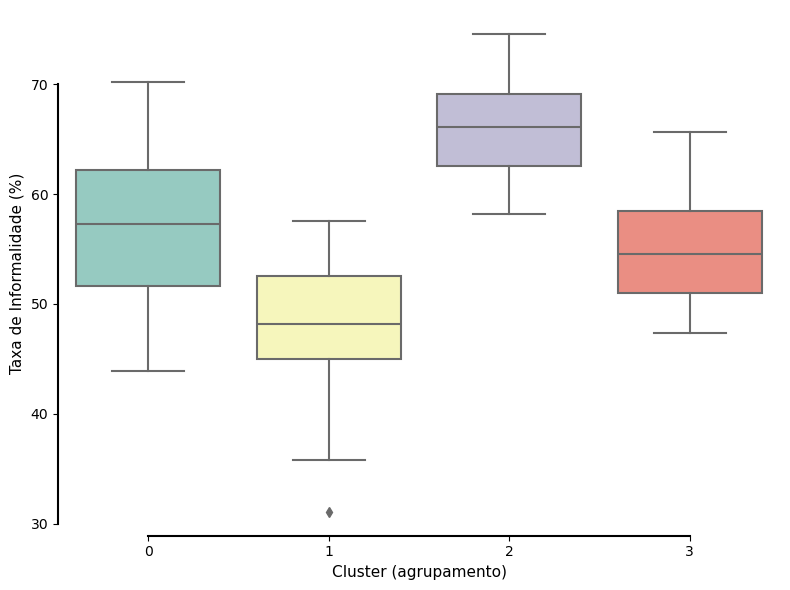

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o arquivo CSV fornecido
df_clusters = pd.read_csv("ndvi-empregabilidade-verde-brasil/dados/df_pivotado_clusters.csv")

# Nome da coluna da taxa de informalidade (resumido para uso no gráfico)
col_informal = "Taxa de informalidade das pessoas de 14 anos ou mais de idade ocupadas na semana de referência"

# Criar figura
plt.figure(figsize=(8, 6))

# Criar boxplot com as configurações especificadas
box = sns.boxplot(
    data=df_clusters,
    x='Cluster',
    y=col_informal,
    palette='Set3'
)

# Remover borda, fundo e grade
sns.despine(trim=True)  # remove bordas superiores e laterais

# Ajustar título dos eixos conforme a norma (Arial, tamanho ≤11, cor preta)
box.set_xlabel("Cluster (agrupamento)", fontsize=11, fontname='DejaVu Sans', color='black')
box.set_ylabel("Taxa de Informalidade (%)", fontsize=11, fontname='DejaVu Sans', color='black')

# Ajustar os eixos principais com linha preta de 1.5 pt
for axis in ['bottom', 'left']:
    box.spines[axis].set_linewidth(1.5)
    box.spines[axis].set_color('black')

# Remover título do gráfico conforme norma
plt.title("")

# Salvar figura conforme instrução
plt.tight_layout()
plt.savefig("ndvi-empregabilidade-verde-brasil/figuras/figura_boxplot_informalidade_por_cluster.png", dpi=300)

# Mostrar a figura
plt.show()

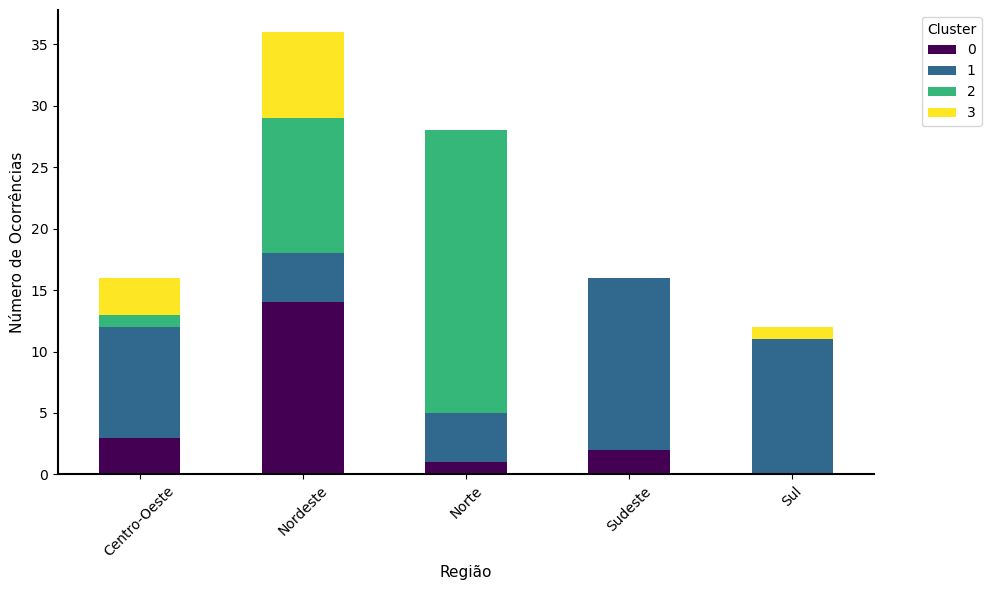

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
file_path = "ndvi-empregabilidade-verde-brasil/dados/df_clusters_com_regiao.csv"
df = pd.read_csv(file_path)

# Contar quantas ocorrências de cada cluster existem em cada região
cluster_counts = df.groupby(["Região", "Cluster"]).size().unstack()

# Criar figura e eixos para aplicar formatação personalizada conforme normas
fig, ax = plt.subplots(figsize=(10, 6))

# Criar gráfico de barras empilhadas sem borda, preenchimento ou grade
cluster_counts.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="viridis",
    edgecolor='none'
)

# Remover título e grade
ax.set_title("")
ax.grid(False)

# Configurar eixos principais com linha preta de 1.5 pt
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_color('black')

# Ocultar bordas superiores e direitas
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Ajustar rótulos dos eixos conforme padrão (Arial ≤ 11, cor preta)
ax.set_xlabel("Região", fontsize=11, fontname='DejaVu Sans', color='black')
ax.set_ylabel("Número de Ocorrências", fontsize=11, fontname='DejaVu Sans', color='black')

# Ajustar ticks e ângulo
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='both', colors='black', labelsize=10)

# Legenda fora do gráfico
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# Salvar o gráfico em PNG com fundo branco
plt.tight_layout()
plt.savefig("ndvi-empregabilidade-verde-brasil/figuras/figura_distribuicao_clusters_por_regiao.png", dpi=300, bbox_inches='tight')
plt.show()

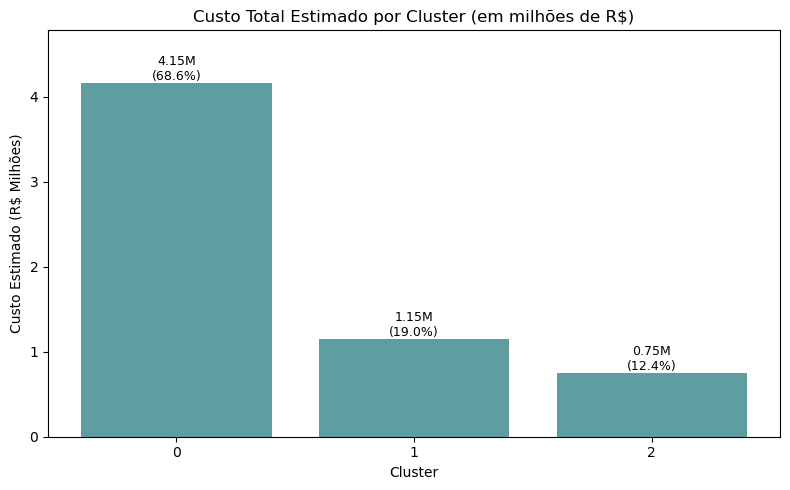

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Ler os dados do arquivo Excel corrigido
df = pd.read_excel("ndvi-empregabilidade-verde-brasil/dados/Tabela_Cluster.xlsx", header=1)  # ajuste o caminho se necessário

# 2) Remover a primeira coluna sem nome
df = df.drop(columns=[df.columns[0]])

# 3) Renomear as colunas
df.columns = [
    "Cluster", "Estado", "Desocupados", "Custo_Estimado", "NDVI",
    "Taxa_Desocupacao", "Taxa_Informalidade", "Regiao"
]

# 4) Garantir que as colunas numéricas estão no formato correto
df["Custo_Estimado"] = pd.to_numeric(df["Custo_Estimado"], errors="coerce")
df["Desocupados"] = pd.to_numeric(df["Desocupados"], errors="coerce")

# 5) Agrupar por cluster e somar os valores, removendo clusters com custo zero
df_cluster = df.groupby("Cluster").agg({
    "Custo_Estimado": "sum",
    "Desocupados": "sum"
}).reset_index()

df_cluster = df_cluster[df_cluster["Custo_Estimado"] > 0]

# 6) Calcular os percentuais
custo_total = df_cluster["Custo_Estimado"].sum()
df_cluster["Percentual"] = (df_cluster["Custo_Estimado"] / custo_total) * 100

# 7) Plotar o gráfico
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(
    df_cluster["Cluster"].astype(str),
    df_cluster["Custo_Estimado"] / 1_000_000,
    color="cadetblue"
)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = df_cluster.loc[i, "Percentual"]
    label = f"{height:.2f}M\n({pct:.1f}%)"
    ax.text(bar.get_x() + bar.get_width() / 2, height, label,
            ha="center", va="bottom", fontsize=9)

ax.set_title("Custo Total Estimado por Cluster (em milhões de R$)")
ax.set_xlabel("Cluster")
ax.set_ylabel("Custo Estimado (R$ Milhões)")
ax.set_ylim([0, df_cluster["Custo_Estimado"].max() / 1_000_000 * 1.15])

# Salvar o gráfico em PNG com fundo branco
plt.tight_layout()
plt.savefig("ndvi-empregabilidade-verde-brasil/figuras/figura_custo_por_cluster.png", dpi=300, bbox_inches='tight')
plt.show()

In [50]:
import os

# Criar estrutura básica de pastas novamente após reset
base_path = "ndvi-empregabilidade-verde-brasil"
folders = [
    "dados",            # CSVs, Excel
    "figuras",          # PNGs dos gráficos
    "codigos",          # Scripts Python
    "documentacao"      # Ex: metodologia ou outros documentos auxiliares
]

# Criar as pastas
for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

# Criar README.md com o conteúdo gerado
readme_content = """
# NDVI, Empregabilidade Verde e Sustentabilidade no Brasil

### 🧠 O que se faz aqui?
Este repositório apresenta uma análise integrada entre dados ambientais (NDVI) e indicadores socioeconômicos (desocupação e informalidade) no Brasil, com o objetivo de identificar padrões regionais de vulnerabilidade socioambiental e estimar o custo de políticas públicas sustentáveis de empregabilidade verde, baseando-se na contratação de mão de obra para ações de reflorestamento urbano.

### 🌱 Por quê?
A crise climática e as desigualdades sociais no Brasil exigem soluções que integrem recuperação ambiental e inclusão produtiva. Este estudo evidencia como técnicas de *Machine Learning* e sensoriamento remoto podem apoiar gestores públicos na alocação eficiente de recursos, oferecendo subsídios concretos para políticas alinhadas aos Objetivos de Desenvolvimento Sustentável (ODS 8 e 13) e práticas ESG. As análises ajudam a priorizar investimentos em regiões com maior desmatamento e vulnerabilidade social, promovendo desenvolvimento sustentável e justiça ambiental.

### 🔍 Como?
Foram utilizados dados do NDVI via Google Earth Engine e dados da PNADC/IBGE para o ano de 2024. O pipeline incluiu:

- 🛰️ Extração e processamento do NDVI (MODIS/MOD13Q1) e indicadores socioeconômicos.
- 📊 Integração e análise estatística das variáveis.
- 🧪 Clusterização via algoritmo *K-Means* para segmentar os estados brasileiros em grupos socioambientais.
- 💰 Modelagem econômica para estimar o custo de programas públicos de reflorestamento com contratação de trabalhadores desempregados ao salário mínimo de R$ 1.518,00 por 6 meses.
- 📈 Geração de gráficos e mapas com visualizações das análises feitas, seguindo as normas acadêmicas da USP ESALQ.

Todos os códigos, figuras e resultados estão organizados neste repositório de forma transparente e replicável.
"""

readme_path = os.path.join(base_path, "README.md")
with open(readme_path, "w", encoding="utf-8") as f:
    f.write(readme_content)

readme_path  # Caminho para download ou visualização do README.md

'ndvi-empregabilidade-verde-brasil/README.md'

In [ ]:
import shutil
from pathlib import Path

# Caminho da pasta raiz do repositório
repo_path = Path("ndvi-empregabilidade-verde-brasil")

# Caminho para o arquivo zipado que será gerado
zip_output_path = "ndvi-empregabilidade-verde-brasil/documentacao/ndvi-empregabilidade-verde-brasil.zip"

# Compactar a pasta como um arquivo .zip
shutil.make_archive(zip_output_path.replace(".zip", ""), 'zip', repo_path)

zip_output_path

readme_path  # Caminho para download ou visualização do README.md

In [58]:
import shutil

# Lista dos diretórios a serem compactados separadamente
pastas = [
    "ndvi-empregabilidade-verde-brasil/codigos",
    "ndvi-empregabilidade-verde-brasil/dados",
    "ndvi-empregabilidade-verde-brasil/documentacao",
    "ndvi-empregabilidade-verde-brasil/figuras"
]

# Caminhos para salvar os arquivos ZIP
zip_paths = []

# Compactar cada pasta individualmente
for pasta in pastas:
    nome_zip = pasta.split("/")[-1]
    zip_path = f"/mnt/data/{nome_zip}.zip"
    shutil.make_archive(zip_path.replace(".zip", ""), 'zip', pasta)
    zip_paths.append(zip_path)

zip_paths


OSError: [Errno 122] Disk quota exceeded